In [1]:
from functions import *

In [2]:
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap

# create new colormap
N = 256
vals = np.ones((N, 3))
color = 'tab:red'
rgb = np.array([220, 10, 10])/256
vals[:, 0] = np.linspace(1, rgb[0], N)
vals[:, 1] = np.linspace(1, rgb[1], N)
vals[:, 2] = np.linspace(1, rgb[2], N)
newcmp = ListedColormap(vals)

options = {
    'cmap': newcmp, 
    'norm': colors.LogNorm(vmin=9e-3, vmax=0.01)
}

In [3]:
n = 8
m = RandomIsingModel(n, seed=2)
print(m)

Ising model information:
Number of spins: 8
External fields (h): [-0.41675785 -0.05626683 -2.1361961   1.64027081 -1.79343559 -0.84174737
  0.50288142 -1.24528809]
Interaction matrix (J):
[[ 0.00000000e+00 -5.62668272e-02 -2.13619610e+00  1.64027081e+00
  -1.79343559e+00 -8.41747366e-01  5.02881417e-01 -1.24528809e+00]
 [-5.62668272e-02  0.00000000e+00  5.51454045e-01  2.29220801e+00
   4.15393930e-02 -1.11792545e+00  5.39058321e-01 -5.96159700e-01]
 [-2.13619610e+00  5.51454045e-01  0.00000000e+00  9.02525097e-03
  -8.78107893e-01 -1.56434170e-01  2.56570452e-01 -9.88779049e-01]
 [ 1.64027081e+00  2.29220801e+00  9.02525097e-03  0.00000000e+00
  -1.42121723e+00 -1.53495196e-01 -2.69056960e-01  2.23136679e+00]
 [-1.79343559e+00  4.15393930e-02 -8.78107893e-01 -1.42121723e+00
   0.00000000e+00 -8.44213704e-01  9.76147160e-06  5.42352572e-01]
 [-8.41747366e-01 -1.11792545e+00 -1.56434170e-01 -1.53495196e-01
  -8.44213704e-01  0.00000000e+00  6.11340780e-01  4.79705919e-02]
 [ 5.02881417e

In [4]:
Q = get_proposal_mat_quantum_layden(m)

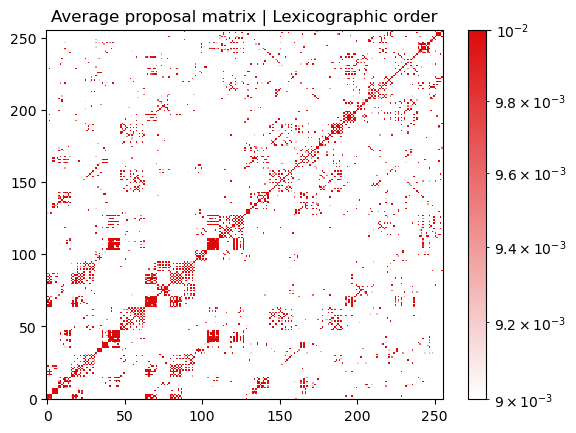

In [5]:
pc = plt.pcolor(np.arange(2**n), 
                np.arange(2**n), 
                Q,
                **options
                )
plt.colorbar(pc)
plt.title('Average proposal matrix | Lexicographic order')
plt.show()

# Sort by energy

In [6]:
sort_ids = np.argsort(m.E)
E_sorted = m.E[sort_ids]
Q_sorted = Q.copy()
Q_sorted = Q_sorted[sort_ids]
Q_sorted = Q_sorted[:, sort_ids]

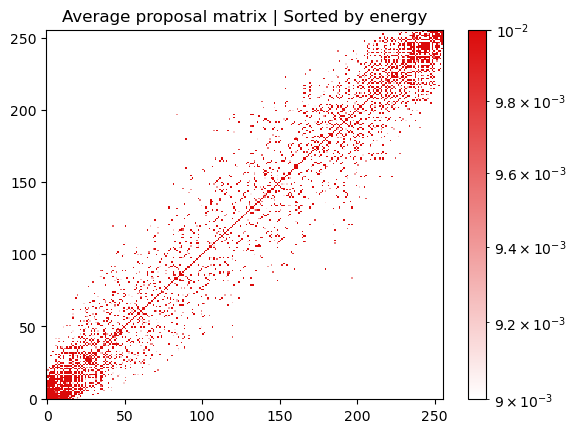

In [7]:
pc = plt.pcolor(np.arange(2**n), 
                np.arange(2**n), 
                Q_sorted,
                **options
                )
plt.colorbar(pc)
plt.title('Average proposal matrix | Sorted by energy')
plt.show()

# Entropies

In [8]:
entropies = np.zeros(2**n)
for i in range(2**n):
    entropies[i] = -sum(Q_sorted[i] * np.log2(Q_sorted[i], where=Q_sorted[i]>0, out=np.zeros_like(entropies)))

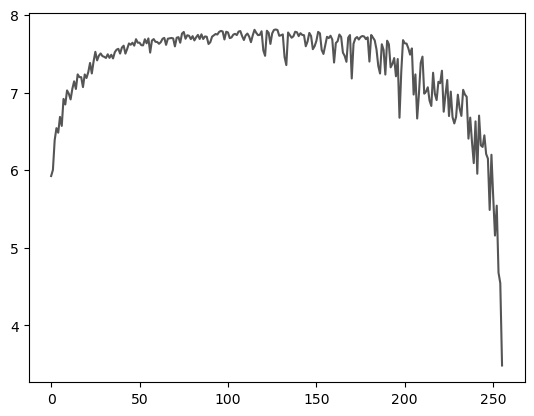

In [9]:
plt.plot(np.arange(2**n), entropies, color=dark_grey)
plt.show()

# Average Hamming distance